# Importation du dataset

Maintenant que la correlation est achevée, nous pouvons travailler sur le jeu de donnée final "general_data.csv".

In [313]:
import pandas as pd

path = "./Datasets/"
general_data = pd.read_csv(path +"general_data.csv")

general_data.head()

,Attrition,BusinessTravel,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,AttendanceScore
0,-0.438422,-0.162399,-1.322079,-0.981014,-0.679146,-1.155935,0.252200,1.156302,-0.244123
1,2.280906,1.717339,-0.678877,-0.327893,-0.368715,-0.034520,0.252200,-0.663899,0.013564
2,-0.438422,1.717339,-0.807517,-0.327893,-0.679146,-0.314873,-0.665460,-0.663899,-0.513073
3,-0.438422,-2.042138,0.221606,0.161947,1.493867,0.245834,1.169861,1.156302,-0.378424
4,-0.438422,-0.162399,-0.292956,-0.164613,-0.679146,-0.034520,1.169861,-1.573999,0.227886


# Jeu de test et d'entrainement
Dans l'objectif d'éviter tout surapprentissage, nous avons divisé notre jeu de donnée en jeu de test et jeu d'entrainement. Le jeu de test est consititué de 30% du total de nos données et le jeu d'entrainement, les 70% restant.

Ainsi, nous allons entrainer nos modèles sur le jeu d'entrainment puis vérifirons l'efficacité du modèle grâce au jeu de test. Cela nous premettra dans le même temps de détecter l'éventuelle surapprentissage.

In [314]:
# Split the data into a training and test set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(general_data.drop("Attrition", axis=1), general_data.Attrition, test_size=0.3, random_state=42)

y_train_yes = (y_train > 0)
y_test_yes = (y_test > 0)

La partie ci-dessous permet d'éviter la répétition de code. En effet, chaque modèles sera entrainer puis évaluer de la même manière. Ce qui facilitera la comparaison des performance entre les modèles.

Dans un premier temps, les modèles seront entrainer.

Le deuxième étapes est la cross validation. Cela consiste à diviser les données en plusieurs sous-ensembles pour évaluer les performances du modèle de manière robuste en utilisant des combinaisons différentes de données d'entraînement et de test. La cross validation permet d'estimer la précision d'une estimation via l'écart type.

Puis s'enchaine d'autre vérification :
- La matrice de confusion récapitule les performances d'un modèle de classification.
- La précision mesure la proportion d'instances correctement prédites parmi celles prédites comme positives.
- Le rappel quantifie la proportion d'instances positives correctement prédites parmi toutes les instances réellement positives.
- Le F1-score combine précision et rappel pour fournir une mesure globale de la performance.
- L'accuracy représente le taux global de prédictions correctes.
- L'aire sous la courbe ROC (ROC AUC) évalue la capacité de discrimination du modèle entre les classes positives et négatives.

On affiche ensuite la courbe de seuil (ou courbe Threshold) ainsi que la courbe ROC.

In [315]:
from matplotlib import pyplot as plt
from sklearn.calibration import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve

def test_model(model, x, y, method):
    # Entraîner le modèle
    model.fit(x, y)
    
    # Validation croisée
    y_train_pred = cross_val_predict(model, x, y, cv=5)

    # Calcul des scores
    y_scores = cross_val_predict(model, x, y, cv=5, method=method)

    confusion_matrix_score = confusion_matrix(y, y_train_pred)
    print("Confusion matrix :\n", confusion_matrix_score)

    precision = precision_score(y, y_train_pred)
    print("Precision :", precision)

    recall = recall_score(y, y_train_pred)
    print("Recall :", recall)

    f1 = f1_score(y, y_train_pred)
    print("F1_score :", f1)

    accuracy = accuracy_score(y, y_train_pred)
    print("Accuracy :", accuracy)

    roc_auc = roc_auc_score(y, y_train_pred)
    print("AUC :", roc_auc)
    
    # Si method est "decision_function", y_scores est un tableau 1D
    if method == "decision_function":
        # calculer précisions, recalls et seuils pour la courbe ROC
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
        fpr, tpr, thresholds1 = roc_curve(y, y_scores)
    # Si method est "predict_proba", y_scores est un tableau 2D
    else:
        # calculer précisions, recalls et seuils pour la courbe ROC
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:, -1])
        fpr, tpr, thresholds1 = roc_curve(y, y_scores[:, -1])

    # Afficher les courbes Threshold
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.title('Precision and Recall vs Threshold')

    # Afficher les courbes ROC et PR
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    return fpr, tpr


# Descente de gradient

Le premier modèle que nous avons utiliser est la descente de gradient.

La descente de gradient est un algorithme d'optimisation utilisé pour ajuster itérativement les paramètres d'un modèle en calculant la pente de la fonction de perte par rapport à ces paramètres, puis en les ajustant dans la direction opposée à cette pente pour minimiser la perte.

Confusion matrix :
 [[2554   30]
 [ 470   33]]
Precision : 0.5238095238095238
Recall : 0.06560636182902585
F1_score : 0.1166077738515901
Accuracy : 0.8380304502753483
AUC : 0.5269982273541414


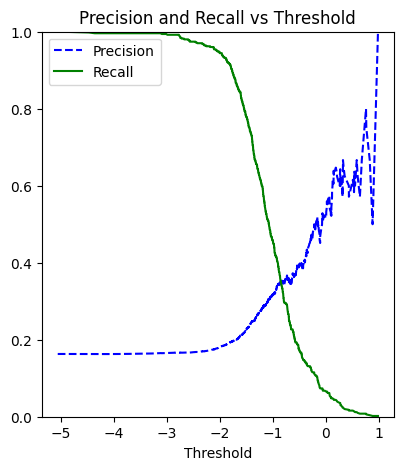

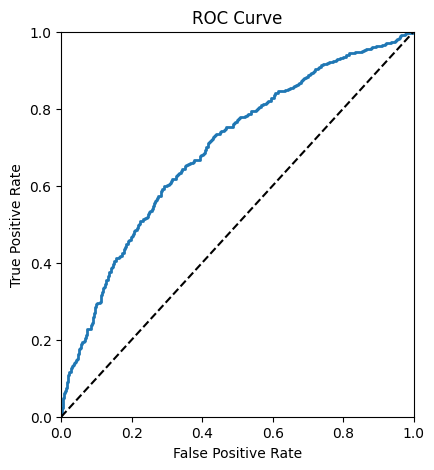

In [316]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

sgd_clf = SGDClassifier(max_iter=1000, random_state=42)

frp_sgd_clf, tpr_sgd_clf = test_model(sgd_clf, X_train, y_train_yes, "decision_function")

Les résultats pour le modèle basé sur la Descente de Gradient (SGD) montrent :

  - Matrice de confusion: Avec 2554 vrais négatifs et 33 vrais positifs, le modèle semble très biaisé vers les prédictions négatives, avec peu de vrais positifs et un nombre relativement faible de faux positifs (30).

  - Précision: 0.5238. Cette valeur est relativement basse, signifiant que lorsque le modèle prédit une classe positive, il est correct un peu plus de la moitié du temps.

  - Rappel: 0.0656. C'est très faible, indiquant que le modèle a manqué une grande partie des vrais positifs.

  - F1-score: 0.1166. Ce score est extrêmement bas, reflétant un mauvais équilibre entre précision et rappel.

  - Accuracy: 0.8380. Bien que cette valeur semble élevée, elle est principalement due à un grand nombre de vrais négatifs, ce qui est commun dans des jeux de données déséquilibrés.

  - AUC: 0.5269. Cette valeur est à peine supérieure à 0.5, indiquant que le modèle ne fait guère mieux que des prédictions aléatoires pour distinguer entre les classes positives et négatives.

La courbe Précision et Rappel versus Seuil montre que pour obtenir un meilleur rappel, la précision chute brutalement et par à-coups. La courbe ROC montre également une performance qui n'est pas très impressionnante, se rapprochant à peine de la ligne de chance.

En résumé, bien que le modèle SGD puisse sembler avoir une exactitude acceptable, les autres mesures indiquent une performance globalement faible, en particulier en termes de rappel et de F1-score. La capacité du modèle à identifier correctement les cas positifs est particulièrement problématique, ce qui peut être critique selon l'application. La courbe ROC confirme cette interprétation, indiquant que le modèle n'est pas efficace pour distinguer entre les classes.

# Random forest classifier

Confusion matrix :
 [[2565   19]
 [ 128  375]]
Precision : 0.9517766497461929
Recall : 0.7455268389662028
F1_score : 0.8361204013377926
Accuracy : 0.9523809523809523
AUC : 0.869086948894866


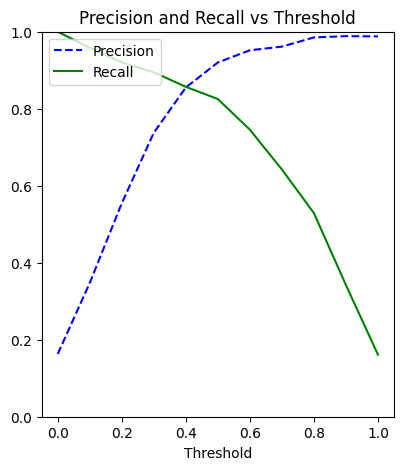

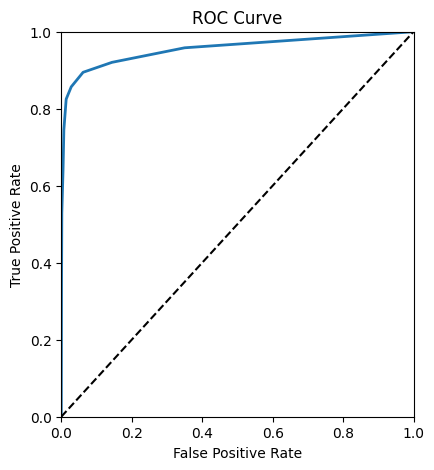

In [317]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)

frp_forest_clf, tpr_forest_clf = test_model(forest_clf, X_train, y_train_yes, "predict_proba")

Les résultats montrent une performance globalement bonne du Random Forest Classifier :

   - Matrice de confusion : Majorité de prédictions correctes avec quelques erreurs. Plus de vrais positifs et vrais négatifs que de faux positifs et faux négatifs.

   - Précision (0.9517) : Le modèle est précis dans ses prédictions positives.

   - Rappel (0.7455) : Le modèle capture une bonne part des cas positifs réels.

   - F1-score (0.8361) : Bon équilibre entre précision et rappel.

   - Accuracy (0.9523) : Haute exactitude globale.

   - AUC (0.8696) : Bonne capacité à distinguer entre les classes.

Les courbes (Precision-Recall vs Threshold et ROC) montrent également de bonnes performances. Malgré cela, il est utile de comparer ces résultats avec ceux d'autres modèles, comme la régression logistique, pour déterminer le meilleur choix pour notre situation.

# Régression logistique
La régression logistique est une technique d'apprentissage supervisé utilisée pour modéliser la probabilité qu'une variable binaire dépendante prenne l'une des deux valeurs possibles en fonction de variables indépendantes. Elle utilise une fonction logistique pour transformer la somme pondérée des variables indépendantes en une probabilité, ce qui permet de prédire la probabilité d'appartenance à une classe spécifique.

Confusion matrix :
 [[2554   30]
 [ 435   68]]
Precision : 0.6938775510204082
Recall : 0.13518886679920478
F1_score : 0.22628951747088186
Accuracy : 0.8493683187560739
AUC : 0.5617894798392309


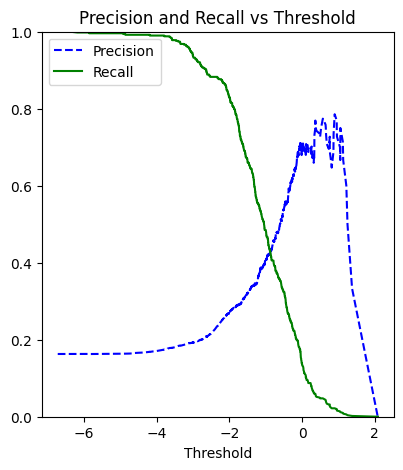

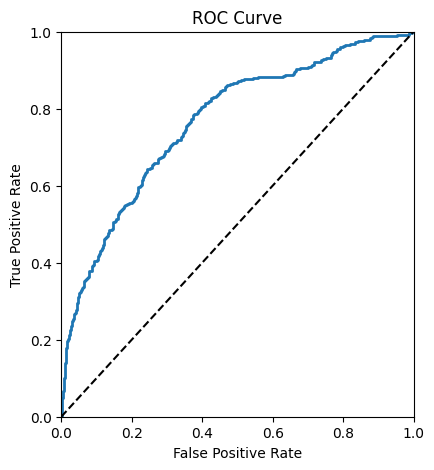

In [318]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

frp_logistic_regression, tpr_logistic_regression = test_model(logistic_regression, X_train, y_train_yes, "decision_function")

   - Matrice de confusion: indique que beaucoup de cas positifs réels sont manqués. 

   - Précision: À 0.6938, cela signifie que lorsqu'il prédit une instance positive, il est correct environ 69,38% du temps, ce qui est assez moyen.

   - Rappel: Très faible à 0.1351, indiquant que le modèle identifie seulement environ 13,51% de tous les cas réels positifs.

   - F1-score: À 0.2263, ce score est assez bas, reflétant le faible équilibre entre précision et rappel.
   - AUC: À 0.5617, ce qui est juste un peu mieux qu'un modèle aléatoire (0.5). C'est une indication que le modèle n'est pas très bon à distinguer les classes positives des négatives.
   
   - Courbes Precision-Recall vs Threshold et ROC: La courbe Precision-Recall montre une baisse significative du rappel avec une augmentation irrégulière de la précision, ce qui n'est pas idéal. La courbe ROC montre une amélioration au-dessus de la ligne de hasard, mais elle n'est pas très prononcée, ce qui indique une performance modérée.

En conclusion, bien que la précision soit raisonnable, le faible rappel, le faible score F1, et l'AUC proche de 0.5 indiquent que le modèle de régression logistique ne performe pas bien, en particulier en identifiant correctement les cas positifs réels. Il pourrait être nécessaire d'ajuster le modèle, d'utiliser un seuil de classification différent, ou d'explorer d'autres modèles pour améliorer les performances.

# Perceptron
Le Perceptron est un modèle d'apprentissage supervisé qui prend des entrées, les pondère, les somme, puis applique une fonction d'activation pour produire une sortie binaire, permettant ainsi la classification linéaire.

Confusion matrix :
 [[2027  557]
 [ 294  209]]
Precision : 0.27284595300261094
Recall : 0.415506958250497
F1_score : 0.32939322301024426
Accuracy : 0.7243278263686427
AUC : 0.5999748413543506


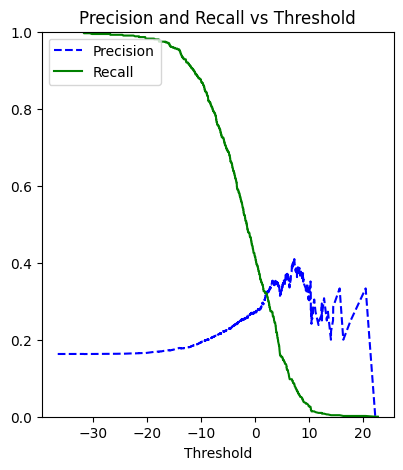

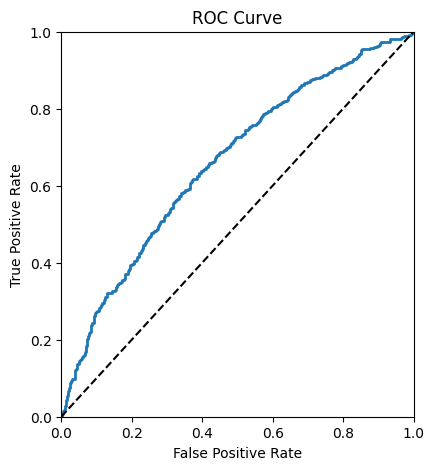

In [319]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=42)

frp_perceptron, tpr_perceptron = test_model(perceptron, X_train, y_train_yes, "decision_function")

Les résultats obtenus pour la régression logistique montrent :

   - Matrice de confusion : Une majorité de prédictions correctes pour la classe négative, mais relativement beaucoup d'erreurs pour la classe positive. La précision globale semble plus faible par rapport au modèle Random Forest précédent.

   - Précision (0.2728) : Faible, ce qui indique que lorsque le modèle prédit une classe positive, il est souvent incorrect.

   - Rappel (0.4156) : Moyen, signifiant que le modèle identifie correctement environ 41,56% des vrais cas positifs.

   - F1-score (0.3299) : Assez bas, indiquant un équilibre médiocre entre précision et rappel.

   - Accuracy (0.7243) : Plus basse que celle du Random Forest, montrant que le modèle fait correctement des prédictions pour environ 72,43% de l'ensemble des données.

   - AUC (0.5999) : Proche de 0.6, ce qui suggère que le modèle a une capacité de distinction entre les classes à peine meilleure qu'un tirage aléatoire.

En résumé, les performances de la régression logistique dans ce cas semblent nettement inférieures à celles du Random Forest, avec une précision, un rappel, et un score AUC relativement bas. Cela peut indiquer que pour le jeu de données et le problème spécifique, la régression logistique n'est pas le modèle le plus adapté.

Passons maintenant au Support Vector Classifier.

# Support Vector Classifier
Le Support Vector Classifier est un algorithme d'apprentissage supervisé qui identifie un hyperplan optimal pour séparer les classes dans un espace de données de manière à maximiser la marge entre les deux classes.

Confusion matrix :
 [[2560   24]
 [ 426   77]]
Precision : 0.7623762376237624
Recall : 0.15308151093439365
F1_score : 0.25496688741721857
Accuracy : 0.8542274052478134
AUC : 0.5718967926188996


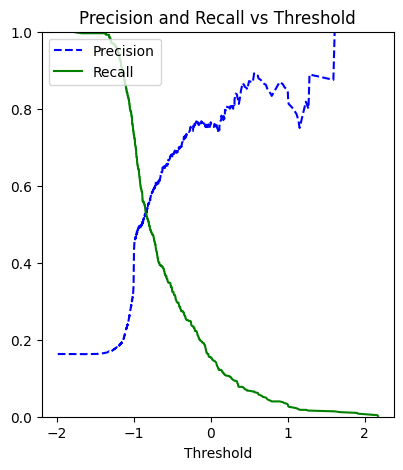

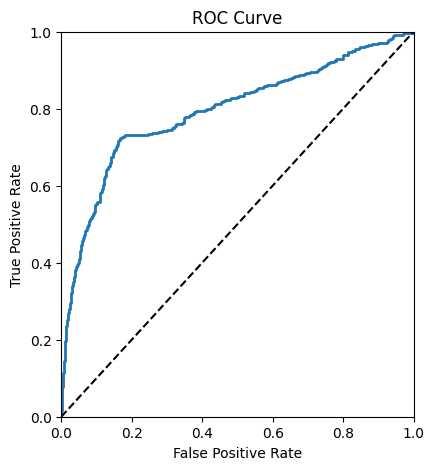

In [320]:
from sklearn.svm import SVC

svc = SVC(random_state=42)

frp_svc, tpr_svc = test_model(svc, X_train, y_train_yes, "decision_function")

Les résultats obtenus pour le Support Vector Classifier montrent :

   - Matrice de confusion : Il y a une majorité de vrais négatifs mais également un nombre significatif de faux négatifs, ce qui suggère que le modèle pourrait être biaisé vers la classe négative.

   - Précision (0.7623) : Assez élevée, cela indique que lorsque le modèle prédit une classe positive, il est correct dans environ 76,23% des cas.

   - Rappel (0.1538) : Très bas, ce qui signifie que le modèle ne parvient à identifier correctement qu'une faible portion des cas réels positifs.

   - F1-score (0.2549) : Très faible, indiquant un mauvais équilibre entre précision et rappel, principalement dû au faible rappel.

   - Accuracy (0.8542) : Assez haute, cela montre que le modèle fait correctement des prédictions pour environ 85,42% de l'ensemble des données.

   - AUC (0.5718) : Proche de 0.6, ce qui indique que le modèle ne distingue pas bien entre les classes positives et négatives.

Les courbes montrent une grande variation dans la précision à mesure que le seuil change, et une courbe ROC qui est légèrement meilleure que le hasard mais toujours pas idéale. Ces résultats suggèrent que le modèle Perceptron n'est pas très efficace pour ce jeu de données, particulièrement en termes de rappel.

# Arbre de décision
L'arbre de décision est un modèle d'apprentissage supervisé qui partitionne récursivement l'espace des données en sous-ensembles homogènes en fonction des caractéristiques, permettant ainsi de prendre des décisions en suivant un chemin de branches basé sur les règles conditionnelles.

Confusion matrix :
 [[2492   92]
 [  89  414]]
Precision : 0.8181818181818182
Recall : 0.8230616302186878
F1_score : 0.8206144697720515
Accuracy : 0.941367022999676
AUC : 0.8937289575242047


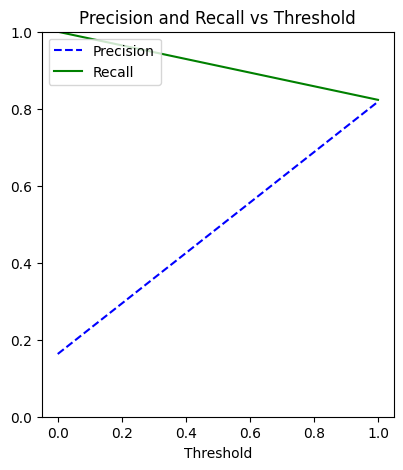

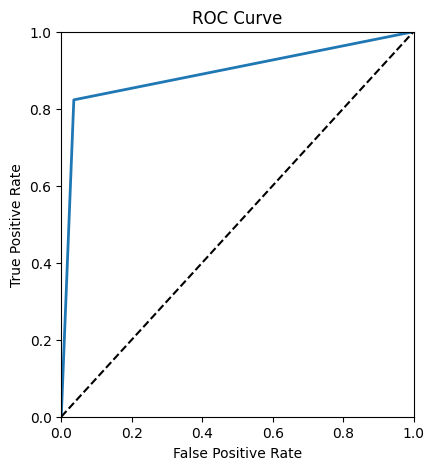

In [321]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)

frp_tree_clf, tpr_tree_clf = test_model(tree_clf, X_train, y_train_yes, "predict_proba")

Les résultats obtenus pour l'Arbre de décision montrent :

   -  Matrice de confusion : Montre une majorité de prédictions correctes pour les deux classes. Le modèle semble bien équilibré entre la sensibilité aux classes positives et négatives.

   - Précision (0.8182) : Très bonne, indiquant que le modèle est fiable lorsqu'il prédit une classe positive.

   - Rappel (0.8236) : Également très bon, ce qui signifie que le modèle est capable d'identifier une grande proportion des cas positifs réels.

   - F1-score (0.8206) : Élevé, indiquant un bon équilibre entre précision et rappel.

   - Accuracy (0.9413) : Très élevée, montrant que le modèle fait correctement des prédictions pour environ 94,13% de l'ensemble des données.

   - AUC (0.8937) : Très bon, indiquant que le modèle a une excellente capacité de distinction entre les classes positives et négatives.

Les courbes montrent une forte performance du modèle, avec une bonne stabilité entre précision et rappel et une courbe ROC qui montre une excellente séparation des classes. Globalement, ces résultats suggèrent que l'Arbre de décision performe bien sur ce jeu de données, avec une haute précision, un bon rappel et une excellente AUC.

# KNeighborsClassifier
Le classificateur K plus proches voisins (KNeighborsClassifier) est un algorithme d'apprentissage supervisé qui classe de nouveaux points de données en se basant sur la classe majoritaire parmi leurs voisins les plus proches dans l'espace des caractéristiques.

Confusion matrix :
 [[2433  151]
 [ 318  185]]
Precision : 0.5505952380952381
Recall : 0.36779324055666
F1_score : 0.4410011918951132
Accuracy : 0.8480725623582767
AUC : 0.65467835402446


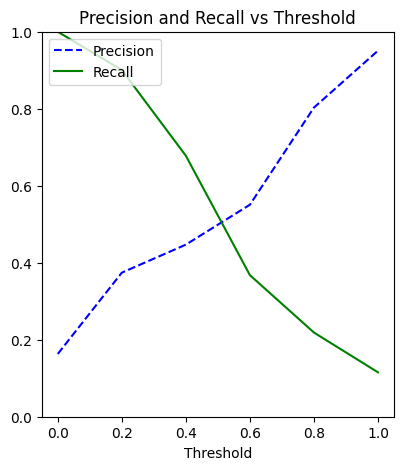

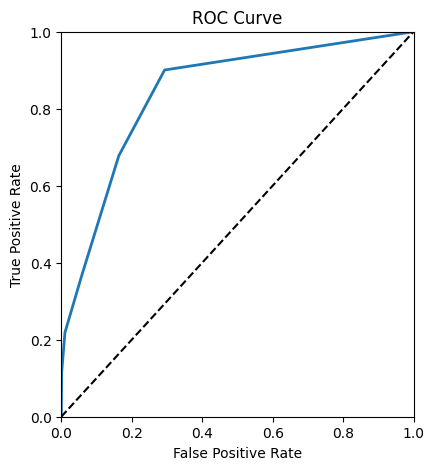

In [322]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

frp_knn, tpr_knn = test_model(knn, X_train, y_train_yes, "predict_proba")

Les résultats pour le KNeighborsClassifier sont :

   - Matrice de confusion : Le modèle a bien performé pour les prédictions négatives mais moins bien pour les positives, avec un nombre significatif de faux négatifs.

   - Précision (0.5595) : Modérée, ce qui signifie que lorsque le modèle prédit positif, il est correct un peu plus de la moitié du temps.

   - Rappel (0.3677) : Assez faible, indiquant que le modèle capture moins de la moitié des cas positifs réels.

   - F1-score (0.4410) : Bas, reflétant le mauvais équilibre entre précision et rappel.

   - Accuracy (0.8480) : Relativement élevée, ce qui indique que le modèle fait correctement des prédictions pour environ 84,80% de l'ensemble des données.

   - AUC (0.6546) : Modéré, indiquant que le modèle a une capacité raisonnable de distinguer entre les classes positives et négatives.

La courbe Precision and Recall vs Threshold montre une grande disparité entre la précision et le rappel, et la courbe ROC suggère que le modèle a une performance juste au-dessus du hasard. Ces résultats suggèrent que le KNeighborsClassifier a une performance modérée sur ce jeu de données, avec des problèmes particuliers pour identifier correctement les cas positifs.

# Nearest Neighbors
Le Nearest Neighbors est un algorithme simple où la prédiction pour une observation est faite en fonction des observations les plus proches dans l'espace des caractéristiques, en se basant sur une mesure de distance spécifiée.

Confusion matrix :
 [[2449  135]
 [ 348  155]]
Precision : 0.5344827586206896
Recall : 0.3081510934393638
F1_score : 0.39092055485498106
Accuracy : 0.8435374149659864
AUC : 0.6279532556980101


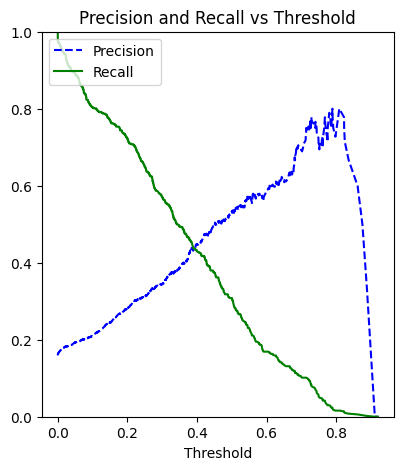

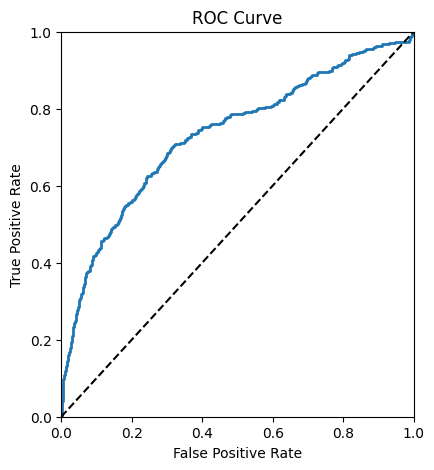

In [323]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

frp_naive_bayes, tpr_naive_bayes = test_model(naive_bayes, X_train, y_train_yes, "predict_proba")

Les résultats pour le Nearest Neighbors sont :

   - Matrice de confusion : Une majorité de vrais négatifs mais un nombre notable de faux négatifs, suggérant une tendance à prédire la classe négative.

   - Précision (0.5344) : Modeste, indiquant que lorsque le modèle prédit une classe positive, il est correct un peu plus de la moitié du temps.

   - Rappel (0.3083) : Assez faible, montrant que le modèle n'identifie qu'une petite partie des cas positifs réels.

   - F1-score (0.3929) : Bas, ce qui reflète un mauvais équilibre entre précision et rappel.

  - Accuracy (0.8435) : Relativement élevée, signifiant que le modèle prédit correctement environ 84,35% de toutes les instances.

  - AUC (0.6279) : Proche de 0.6, indiquant une capacité limitée à distinguer entre les classes positives et négatives.

La courbe de précision et de rappel montre une divergence importante entre ces deux métriques, indiquant un compromis marqué entre elles. La courbe ROC montre une performance meilleure que le hasard mais encore loin d'être idéale.

En résumé, le Nearest Neighbors a une performance modeste dans ce contexte, avec des problèmes principaux étant la faible précision et le faible rappel, suggérant qu'il pourrait ne pas être le modèle le plus approprié pour ces données spécifiques.

# Comparaison
Nous allons désormais comparer les résultats des différents modèles pour choisir celui nous donnant les meilleurs résultats.

Pour ce faire, nous avons rassembler toutes les courbes ROC sur un même graphique. Pour rappel, une courbe ROC idéale serait située dans le coin supérieur gauche du graphique, ce qui indiquerait une sensibilité élevée (taux de vrais positifs élevé) et une spécificité élevée (taux de faux positifs faible). Plus la courbe ROC se rapproche de ce coin, meilleure est la performance du modèle.
Nous cherchons donc a nous rapprocher au maximum de ce coin idéal.

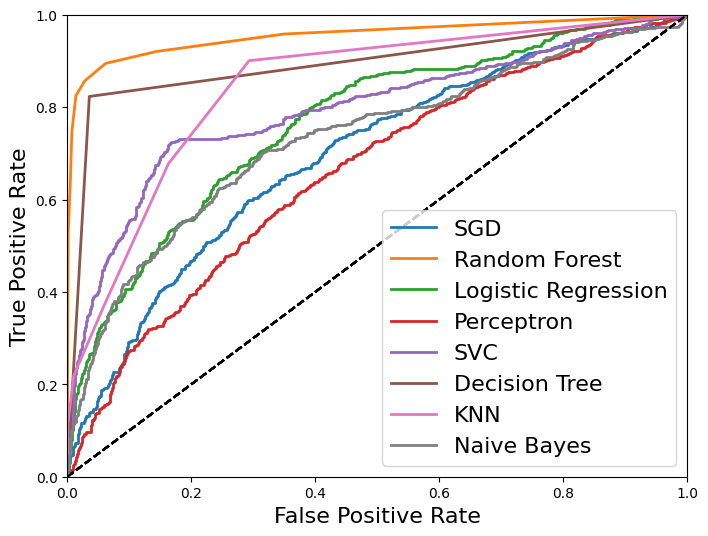

In [324]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(frp_sgd_clf, tpr_sgd_clf, "SGD")
plot_roc_curve(frp_forest_clf, tpr_forest_clf, "Random Forest")
plot_roc_curve(frp_logistic_regression, tpr_logistic_regression, "Logistic Regression")
plot_roc_curve(frp_perceptron, tpr_perceptron, "Perceptron")
plot_roc_curve(frp_svc, tpr_svc, "SVC")
plot_roc_curve(frp_tree_clf, tpr_tree_clf, "Decision Tree")
plot_roc_curve(frp_knn, tpr_knn, "KNN")
plot_roc_curve(frp_naive_bayes, tpr_naive_bayes, "Naive Bayes")
plt.legend(loc="lower right", fontsize=16)
plt.show()

Voici l'analyse du graphique :

- **SGD (Descente de Gradient Stochastique)** : la courbe est proche de la ligne diagonale, suggérant une performance à peine meilleure qu'un choix aléatoire.
- **Random Forest** : Cette courbe est la plus performante, s'approchant beaucoup du coin supérieur gauche.
- **Logistic Regression (Régression Logistique)** : La performance est bonne mais pas aussi bonne que celle du Random Forest.
- **Perceptron** : La courbe est notablement en dessous des meilleurs modèles, indiquant une performance inférieure.
- **SVC (Support Vector Classifier)** : Performe bien, la courbe est assez proche de celle du Random Forest mais légèrement en dessous.
- **Decision Tree (Arbre de Décision)** : Sa performance est inférieure à celle de Random Forest et SVC.
- **KNN (K-Nearest Neighbors)** : La courbe montre une performance modeste, mieux que le Perceptron mais moins bonne que les meilleurs modèles.
- **Naive Bayes** : La courbe représente un résultat médiocre et à peine mieux que le modèle SGD.

En analysant ces courbes, le **Random Forest** semble offrir la meilleure performance pour ce jeu de données spécifique, étant donné que sa courbe ROC est la plus proche du coin supérieur gauche, indiquant le meilleur équilibre entre le taux de vrais positifs et le taux de faux positifs. Nous sélectionnons donc le **Random Forest** pour notre modèle.

# GridSearchCV
GridSearchCV est une technique utilisée en apprentissage automatique pour rechercher de manière exhaustive les meilleurs hyperparamètres d'un modèle en évaluant toutes les combinaisons possibles à partir d'une grille prédéfinie, ce qui permet d'optimiser les performances du modèle sur un ensemble de données donné.

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Meilleurs hyperparamètres: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Confusion matrix :
 [[2570   14]
 [  75  428]]
Precision : 0.9683257918552036
Recall : 0.8508946322067594
F1_score : 0.9058201058201059
Accuracy : 0.971169420149012
AUC : 0.9227383377752063


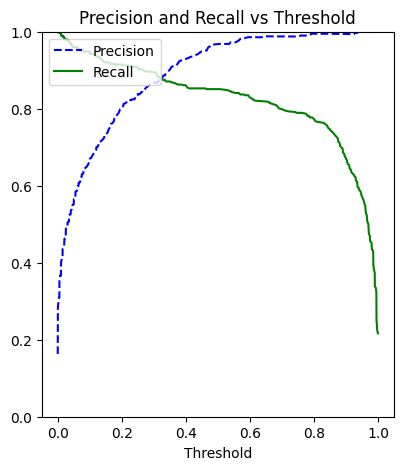

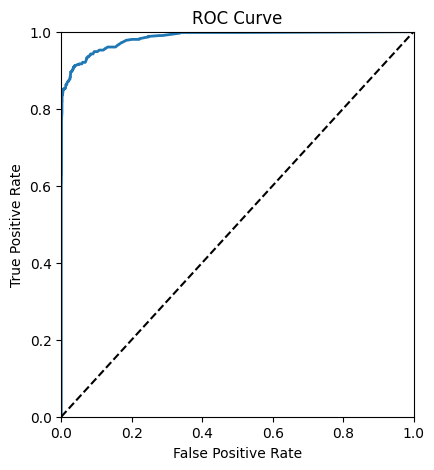

In [336]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

# Supposons que X_train, X_test, y_train, y_test soient déjà définis

# Définition de la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres dans la forêt
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],    # Nombre minimum d'échantillons requis à chaque feuille
    'bootstrap': [True, False]        # Méthode d'échantillonnage des ensembles de données
}

# Recherche en grille avec validation croisée
grid_search = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustement du modèle GridSearchCV
grid_search.fit(X_train, y_train_yes)

# Affichage de la meilleure combinaison d'hyperparamètres
print(f'Meilleurs hyperparamètres: {grid_search.best_params_}')

# Entraînement du modèle avec la meilleure combinaison d'hyperparamètres
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

test_model(best_grid, X_train, y_train_yes, "predict_proba")

Sur la base des résultats de GridSearchCV pour le modèle Random Forest, les meilleurs hyperparamètres trouvés sont :

- `'bootstrap': False` : Ce paramètre indique que tout l'ensemble de données est utilisé pour construire chaque arbre.
- `'max_depth': 20` : La profondeur maximale de chaque arbre est limitée à 20 niveaux.
- `'min_samples_leaf': 1` : Un nœud est considéré comme une feuille s'il contient 1 échantillon au minimum.
- `'min_samples_split': 2` : Un nœud est divisé s'il contient au moins 2 échantillons.
- `'n_estimators': 200` : Le nombre total d'arbres dans la forêt est de 200.

Ces paramètres reflètent une combinaison qui a donné les meilleures performances lors de la validation croisée effectuée par GridSearchCV, comme indiqué par les scores élevés en précision, rappel, F1-score, exactitude et la valeur AUC.

La matrice de confusion et les mesures de performance suggèrent une forte performance du modèle avec ces hyperparamètres. La courbe ROC est également très proche du coin supérieur gauche, indiquant une excellente capacité de séparation des classes positives et négatives. Les résultats de la précision et du rappel par rapport au seuil montrent que vous pouvez ajuster le seuil pour équilibrer la précision et le rappel selon vos besoins spécifiques.

Ces résultats suggèrent que la configuration des hyperparamètres choisie par GridSearchCV est efficace pour votre modèle Random Forest sur le jeu de données actuel.

# Threshold
Le seuil (threshold) est un paramètre utilisé dans les modèles de classification pour décider quelle classe assigner à une observation en fonction de la probabilité de cette observation d'appartenir à chaque classe, où le seuil est comparé à la probabilité prédite pour prendre la décision de classification.

In [339]:
# application du threshold dans le modèle 

# Sélection du seuil
threshold = 0.355

# Prédiction des probabilités
y_pred_proba = best_grid.predict_proba(X_test)[:, 1]

# Prédiction des classes
y_pred = (y_pred_proba >= threshold).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test_yes, y_pred)

# Affichage de la matrice de confusion
print('Matrice de confusion:')
print(cm)

# Calcul de la précision
precision = precision_score(y_test_yes, y_pred)
print(f'Précision: {precision:.2f}')

# Calcul du rappel
recall = recall_score(y_test_yes, y_pred)
print(f'Rappel: {recall:.2f}')

# Calcul du F1-score
f1 = f1_score(y_test_yes, y_pred)
print(f'F1-score: {f1:.2f}')

# Calcul de l'aire sous la courbe ROC
roc_auc = roc_auc_score(y_test_yes, y_pred_proba)
print(f'AUC: {roc_auc:.2f}')

Matrice de confusion:
[[1098   17]
 [  15  193]]
Précision: 0.92
Rappel: 0.93
F1-score: 0.92
AUC: 0.99


Les résultats obtenus avec le Random Forest sur l'ensemble de données de test, en utilisant un seuil de 0.355, sont très bons :

- **Matrice de confusion** : Vous avez 1098 vrais négatifs et 193 vrais positifs, ce qui est excellent. Il y a seulement 17 faux positifs et 15 faux négatifs, indiquant que le modèle est très performant à la fois pour identifier les cas positifs et négatifs correctement.

- **Précision**: 0.92. Cela signifie que 92% des prédictions positives du modèle étaient correctes.

- **Rappel**: 0.93. Cela signifie que le modèle a correctement identifié 93% de tous les vrais cas positifs dans l'ensemble de données de test.

- **F1-score**: 0.92. Ce score, étant une moyenne harmonique de la précision et du rappel, indique un très bon équilibre entre ces deux mesures.

- **AUC**: 0.99. Une valeur proche de 1 indique une excellente capacité du modèle à distinguer entre les classes positives et négatives.

Ces résultats montrent que le modèle Random Forest, avec les hyperparamètres optimisés et un seuil ajusté, fonctionne exceptionnellement bien sur vos données de test. Un AUC de 0.99 est particulièrement remarquable et suggère que le modèle est très performant dans la classification des observations.